# Import Libraries

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans

# EDA

In [18]:
# Load the data
data = pd.read_excel(r'/Users/prithvishams/Documents/Bootcamp Concordia/M2P12-Classification_Project-main/churn.xlsx')

<u>Country</u> and <u>State</u> all have a single value, hence these can be dropped <br>
Billing method and paper/paperless billing have no influence on customer retention, hence dropping these columns <br>
<u>Total Charges</u> column makes <u>Monthly Charges</u> column redundant <br>
<u>Churn Value</u> makes <u>Churn Label</u> redundant <br>
<u>Churn Reason</u> column has 6000 + missing values in a dataset of 7000 datapoints, hence, dropping this column.<br>
<br>
We will transform lat and lon data into a categorical column, so <u>zip code</u> is redundant location information.


In [19]:
# Drop unnecessary columns
df = data.drop(['CustomerID','Count','Country','State','City','Lat Long','Zip Code','Paperless Billing','Payment Method','Monthly Charges','Churn Label','Churn Reason'], axis=1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Latitude           7043 non-null   float64
 1   Longitude          7043 non-null   float64
 2   Gender             7043 non-null   object 
 3   Senior Citizen     7043 non-null   object 
 4   Partner            7043 non-null   object 
 5   Dependents         7043 non-null   object 
 6   Tenure Months      7043 non-null   int64  
 7   Phone Service      7043 non-null   object 
 8   Multiple Lines     7043 non-null   object 
 9   Internet Service   7043 non-null   object 
 10  Online Security    7043 non-null   object 
 11  Online Backup      7043 non-null   object 
 12  Device Protection  7043 non-null   object 
 13  Tech Support       7043 non-null   object 
 14  Streaming TV       7043 non-null   object 
 15  Streaming Movies   7043 non-null   object 
 16  Contract           7043 

## Data Preprocessing

<b>Multiple Lines</b><br>
Indicates whether the customer subscribes to multiple telephone lines with the company. This column should contain yes/no values. <br>
<i>No phone service</i> shall be standardized to <i>no</i><br>
<br>
Similar cleanup is done in other columns where the customer did not subscribe to the specific service simply because they were not signed up for the internet service.

In [21]:
df['Multiple Lines']=df['Multiple Lines'].replace('No phone service','No')
df['Online Security']=df['Online Security'].replace('No internet service','No')
df['Online Backup']=df['Online Backup'].replace('No internet service','No')
df['Device Protection']=df['Device Protection'].replace('No internet service','No')
df['Tech Support']=df['Tech Support'].replace('No internet service','No')
df['Streaming TV']=df['Streaming TV'].replace('No internet service','No')
df['Streaming Movies']=df['Streaming Movies'].replace('No internet service','No')

<b>Convert object to float</b><br>
<u>Total Charges</u> should be float instead of object

In [22]:
#Convert object data type to float
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Total Charges'] = df['Total Charges'].astype(float)
df.dropna(subset=['Total Charges'], inplace=True) #drop 11 rows with missing values

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Latitude           7032 non-null   float64
 1   Longitude          7032 non-null   float64
 2   Gender             7032 non-null   object 
 3   Senior Citizen     7032 non-null   object 
 4   Partner            7032 non-null   object 
 5   Dependents         7032 non-null   object 
 6   Tenure Months      7032 non-null   int64  
 7   Phone Service      7032 non-null   object 
 8   Multiple Lines     7032 non-null   object 
 9   Internet Service   7032 non-null   object 
 10  Online Security    7032 non-null   object 
 11  Online Backup      7032 non-null   object 
 12  Device Protection  7032 non-null   object 
 13  Tech Support       7032 non-null   object 
 14  Streaming TV       7032 non-null   object 
 15  Streaming Movies   7032 non-null   object 
 16  Contract           7032 non-n

## Feature Engineering

### Encoding Geographic data with K-means clustering<br>
We will use Elbow method to find the optimal value of K <br>
Statistical literature recommends a range of 1 to 10 of K values for customer behavior modelling

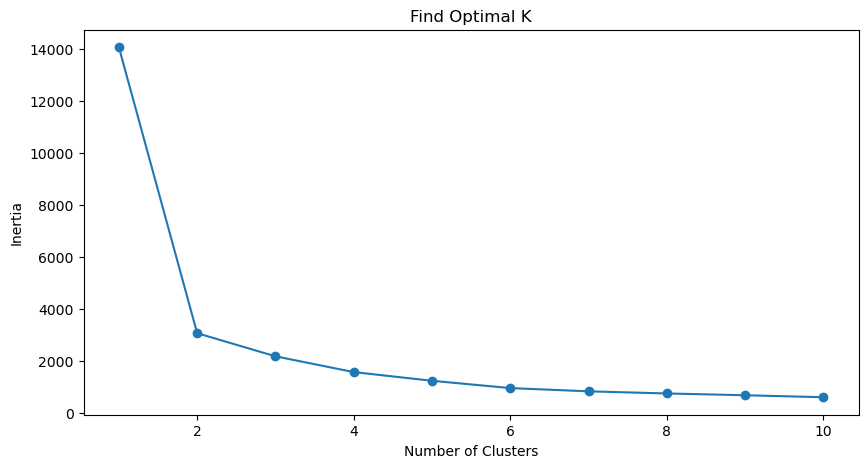

In [24]:
#standardize coordinates to mitigate scale difference between latitude (-90, +90) and longitude (-180, +180)
latlon_scaler = StandardScaler()

scaled_coords = latlon_scaler.fit_transform(df[['Latitude','Longitude']])

inertia = [] #list to store the values of inertia for elbow method plot

for k in range(1,11):
    kmeans = KMeans(n_clusters = k, n_init=10, random_state=42)
    kmeans.fit(scaled_coords)
    inertia.append(kmeans.inertia_)
#Visualize the elbow method
plt.figure(figsize=(10,5))
plt.plot(range(1,11), inertia, marker='o')
plt.title('Find Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

The elbow is observed at K = 2

In [25]:
#Train KMeans with the optimum K
kmeans_final = KMeans(n_clusters = 2, n_init=10, random_state=42)
df['Geo Cluster'] = kmeans_final.fit_predict(scaled_coords)
df['Geo Cluster'].value_counts()

Geo Cluster
1    3524
0    3508
Name: count, dtype: int64

All the location data points were grouped into 2 clusters with equal weights. Apparently, geolocation data may not have any impact on predicitng churn values. We will still retain this column for comparison and drop the rest of the geolocation features

In [26]:
df=df.drop(['Latitude','Longitude'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             7032 non-null   object 
 1   Senior Citizen     7032 non-null   object 
 2   Partner            7032 non-null   object 
 3   Dependents         7032 non-null   object 
 4   Tenure Months      7032 non-null   int64  
 5   Phone Service      7032 non-null   object 
 6   Multiple Lines     7032 non-null   object 
 7   Internet Service   7032 non-null   object 
 8   Online Security    7032 non-null   object 
 9   Online Backup      7032 non-null   object 
 10  Device Protection  7032 non-null   object 
 11  Tech Support       7032 non-null   object 
 12  Streaming TV       7032 non-null   object 
 13  Streaming Movies   7032 non-null   object 
 14  Contract           7032 non-null   object 
 15  Total Charges      7032 non-null   float64
 16  Churn Value        7032 non-n

### Visualize correlation data<br>
Let's look at the correlation between churn value and the numerical features in the dataset

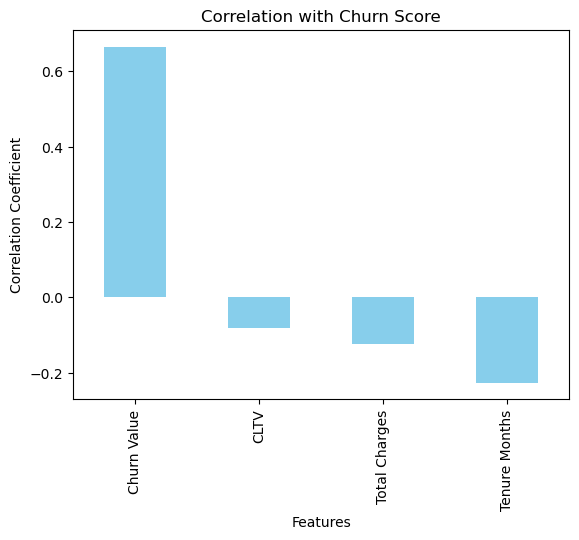

In [27]:
#Calculate correlation matrix
correlation_matrix = df[['Tenure Months','Total Charges','Churn Value','Churn Score','CLTV']].corr()
correlation_with_churn = correlation_matrix["Churn Score"].drop("Churn Score").sort_values(ascending=False) 

correlation_with_churn.plot(kind='bar', color='skyblue')
plt.title('Correlation with Churn Score')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.show()

The figure shows a strong correlation with churn value but a strong negative correlation with tenure, which is expected. According to the figure, the longer the customer stays with the company, the unlikely they are to churn.

### Encoding nominal categories

In [28]:
nominal_cols = ['Gender','Senior Citizen','Partner','Dependents','Phone Service','Multiple Lines','Internet Service','Online Security','Online Backup','Device Protection','Tech Support','Streaming TV','Streaming Movies']

nominal_encoder = OneHotEncoder(drop='first', sparse_output=False)

encoded_nominal_cols_df = pd.DataFrame(nominal_encoder.fit_transform(df[nominal_cols]), columns=nominal_encoder.get_feature_names_out(nominal_cols))

encoded_nominal_cols_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender_Male                   7032 non-null   float64
 1   Senior Citizen_Yes            7032 non-null   float64
 2   Partner_Yes                   7032 non-null   float64
 3   Dependents_Yes                7032 non-null   float64
 4   Phone Service_Yes             7032 non-null   float64
 5   Multiple Lines_Yes            7032 non-null   float64
 6   Internet Service_Fiber optic  7032 non-null   float64
 7   Internet Service_No           7032 non-null   float64
 8   Online Security_Yes           7032 non-null   float64
 9   Online Backup_Yes             7032 non-null   float64
 10  Device Protection_Yes         7032 non-null   float64
 11  Tech Support_Yes              7032 non-null   float64
 12  Streaming TV_Yes              7032 non-null   float64
 13  Str

In [29]:
# drop original nominal features and add encoded nominal features
encoded_df = df.drop(nominal_cols, axis=1).join(encoded_nominal_cols_df)

### Encoding Ordinal Category

The only ordinal category in the dataset is <u>Contract</u> <br>
These categorical values are encoded on the assumption that companes place a higher weight on long-term contracts than month-to-month contracts.

In [30]:
order = ['Month-to-month','One year','Two year']
ordinal_encoder = OrdinalEncoder(categories=[order])
encoded_df['Contract_encoded'] = ordinal_encoder.fit_transform(df[['Contract']])
encoded_df.drop('Contract', axis=1, inplace=True)
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Tenure Months                 7032 non-null   int64  
 1   Total Charges                 7032 non-null   float64
 2   Churn Value                   7032 non-null   int64  
 3   Churn Score                   7032 non-null   int64  
 4   CLTV                          7032 non-null   int64  
 5   Geo Cluster                   7032 non-null   int32  
 6   Gender_Male                   7021 non-null   float64
 7   Senior Citizen_Yes            7021 non-null   float64
 8   Partner_Yes                   7021 non-null   float64
 9   Dependents_Yes                7021 non-null   float64
 10  Phone Service_Yes             7021 non-null   float64
 11  Multiple Lines_Yes            7021 non-null   float64
 12  Internet Service_Fiber optic  7021 non-null   float64
 13  Internet

In [ ]:
#Drop null values after ordinal encoding
encoded_df.dropna(inplace=True)
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7021 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Tenure Months                 7021 non-null   int64  
 1   Total Charges                 7021 non-null   float64
 2   Churn Value                   7021 non-null   int64  
 3   Churn Score                   7021 non-null   int64  
 4   CLTV                          7021 non-null   int64  
 5   Geo Cluster                   7021 non-null   int32  
 6   Gender_Male                   7021 non-null   float64
 7   Senior Citizen_Yes            7021 non-null   float64
 8   Partner_Yes                   7021 non-null   float64
 9   Dependents_Yes                7021 non-null   float64
 10  Phone Service_Yes             7021 non-null   float64
 11  Multiple Lines_Yes            7021 non-null   float64
 12  Internet Service_Fiber optic  7021 non-null   float64
 13  Internet